In [1]:
import argparse
swiss_args = argparse.Namespace(
    image_size=[224, 224],
    pre_len=1,
    post_len=0,
    inner_hidden_size=None,
    hidden_size_per_attention_head=None,
    checkpoint_activations=True,
    checkpoint_num_layers=1,
    model_parallel_size=1,
    world_size=1,
    rank=0,
    mode='inference',
    fp16=False,
    bf16=False
    )

import os

os.environ["SAT_HOME"] = "/data/qingsong/pretrain"

import torch
init_method = 'tcp://'
master_ip = os.getenv('MASTER_ADDR', '127.0.0.1')
master_port = os.getenv('MASTER_PORT', '12468')
init_method += master_ip + ':' + master_port
torch.distributed.init_process_group(
        backend='nccl',
        world_size=swiss_args.world_size, rank=swiss_args.rank, init_method=init_method)
import SwissArmyTransformer.mpu as mpu
mpu.initialize_model_parallel(swiss_args.model_parallel_size)
from SwissArmyTransformer.model.official.mae_model import MAE
swiss_model, swiss_args = MAE.from_pretrained(swiss_args, 'mae-vit-base')
model = swiss_model.cuda()

> initializing model parallel with size 1
building MAE model ...
 > number of parameters on model parallel rank 0: 111907840
global rank 0 is loading checkpoint /data/qingsong/pretrain/mae-vit-base/1/mp_rank_00_model_states.pt
  successfully loaded /data/qingsong/pretrain/mae-vit-base/1/mp_rank_00_model_states.pt


In [2]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    # loss, y, mask = model(x.float(), mask_ratio=0.75)
    position_ids = torch.cat([torch.arange(197)[None,]])
    dec_pos = torch.cat([torch.arange(197)[None,]])
    encoded_input = {'input_ids':torch.zeros(1, 1).long(), 'image':x.float(), 'enc_position_ids':position_ids, 'dec_position_ids':dec_pos}
    encoded_input = {k:v.cuda() for k,v in encoded_input.items()}
    encoder_outputs, decoder_outputs, encoder_mems, decoder_mems = model(offline=True, mask_ratio=0.75, **encoded_input)
    y = decoder_outputs
    mask = encoder_mems[0]['mask']
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.encoder.property.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

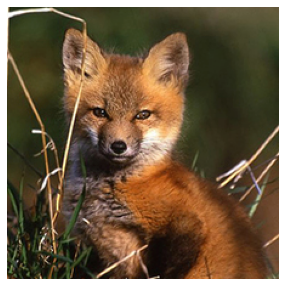

In [3]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

MAE with pixel reconstruction:
[2022-06-16 22:44:08,971] [INFO] [checkpointing.py:547:forward] Activation Checkpointing Information
[2022-06-16 22:44:08,972] [INFO] [checkpointing.py:548:forward] ----Partition Activations False, CPU CHECKPOINTING False
[2022-06-16 22:44:08,972] [INFO] [checkpointing.py:551:forward] ----contiguous Memory Checkpointing False with None total layers
[2022-06-16 22:44:08,973] [INFO] [checkpointing.py:554:forward] ----Synchronization False
[2022-06-16 22:44:08,973] [INFO] [checkpointing.py:555:forward] ----Profiling time in checkpointing False


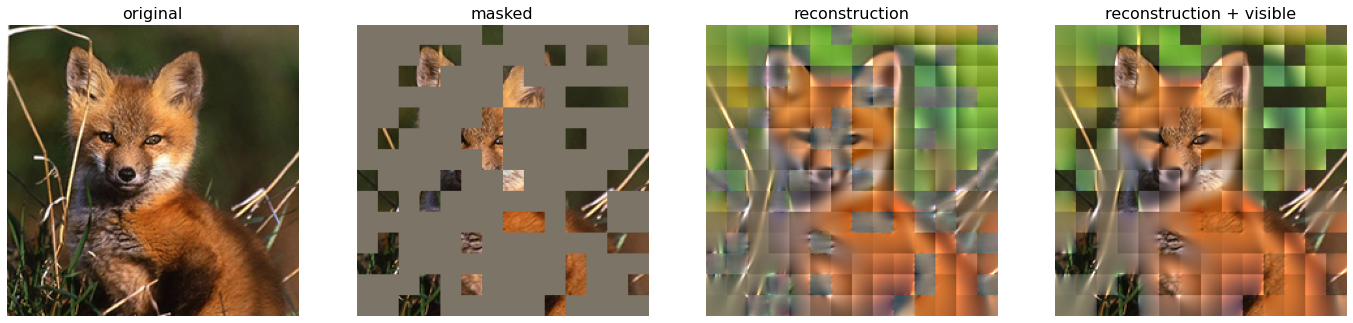

In [4]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model)